## SMARTPHONE PRICE PREDICTION-SUPERVISED LEARNING FINAL PROJECT

### 1) Project Topic
#### 1A) What is the project about? Which type of problem?
- This project builds a data-driven estimator of smartphone prices from technical specifications and metadata. Using features such as battery capacity, RAM, storage, brand, OS, release year, and other attributes, I aim to understand which factors most strongly drive price and to predict the market price for unseen devices.
- Type of learning & task:
    + Learning method: Supervised learning
    + Task type: Regression (target = price)
#### 1B) Goal and Motivation
Smartphone pricing is noisy and influenced by many factors (brand positioning, component performance, release time). Therefore, I want to achieve accurately predict smartphone price from specification data and
Quantify feature importance to explain which device attributes matter most.



In [159]:
import os, re, math, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Utils
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


### 2) Data
#### 2A) Source, Description, and Citation
This dataset was obtained from Kaggle, a public repository of datasets shared by researchers and practitioners. The smartphones data aggregates device specifications ( battery capacity, RAM, storage, OS/brand, release information) and associated market prices. 

The dataset was collected through web scraping from reputable and verified online sources to ensure accuracy and relevance, and provided as a single CSV table suitable for supervised learning.

Abhijit Dahatonde (2023).Real World Smartphone's Dataset[smartphones.csv].Kaggle
https://www.kaggle.com/datasets/abhijitdahatonde/real-world-smartphones-dataset



In [160]:
data_path='data/smartphones.csv'
df=pd.read_csv(data_path)
print(df.shape)
df.head()

(980, 22)


,brand_name,model,price,avg_rating,5G_or_not,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,...,internal_memory,screen_size,refresh_rate,num_rear_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,resolution_height,resolution_width
0,apple,Apple iPhone 11,38999,7.3,0,bionic,6.0,2.65,3110.0,0,...,64,6.1,60,2,ios,12.0,12.0,0,1792,828
1,apple,Apple iPhone 11 (128GB),46999,7.5,0,bionic,6.0,2.65,3110.0,0,...,128,6.1,60,2,ios,12.0,12.0,0,1792,828
2,apple,Apple iPhone 11 Pro Max,109900,7.7,0,bionic,6.0,2.65,3500.0,1,...,64,6.5,60,3,ios,12.0,12.0,0,2688,1242
3,apple,Apple iPhone 12,51999,7.4,1,bionic,6.0,3.10,NaN,0,...,64,6.1,60,2,ios,12.0,12.0,0,2532,1170
4,apple,Apple iPhone 12 (128GB),55999,7.5,1,bionic,6.0,3.10,NaN,0,...,128,6.1,60,2,ios,12.0,12.0,0,2532,1170


#### 2B) Data Description
This dataset has 908 rows and 22 columns with 18 numeric features and 4 categorical features.

Notable features:

- 'avg_rating' contains missing values; impute or exclude rows/feature .

- 'price' is right-skewed; consider log-transform during modeling.

- '5G_or_not' is a binary integer; treat as categorical in interpretation but numeric in modeling.


In [161]:
# Basic info
print("Rows, Cols:", df_raw.shape)
display(df_raw.dtypes.to_frame("dtype"))
print("\nMissing values per column:")
display(df_raw.isna().sum())
print("Duplicate rows:", df_raw.duplicated().sum())


Rows, Cols: (980, 22)


,dtype
brand_name,object
model,object
price,int64
avg_rating,float64
5G_or_not,int64
processor_brand,object
num_cores,float64
processor_speed,float64
battery_capacity,float64
fast_charging_available,int64



Missing values per column:


brand_name                     0
model                          0
price                          0
avg_rating                   101
5G_or_not                      0
processor_brand               20
num_cores                      6
processor_speed               42
battery_capacity              11
fast_charging_available        0
fast_charging                211
ram_capacity                   0
internal_memory                0
screen_size                    0
refresh_rate                   0
num_rear_cameras               0
os                            14
primary_camera_rear            0
primary_camera_front           5
extended_memory_available      0
resolution_height              0
resolution_width               0
dtype: int64

Duplicate rows: 0


### 3) Data cleaning
Cleaning goals:
- I impute median values for missing numeric features and impute missing token for missing categorical features.
- I remove 'num_cores' feature because it showed little variability across samples, making it ineffective for distinguishing between them(most of them have the same value).
- Handle outliers for 'price' and 'battery_capacity'.
- Remove rows with missing target or impossible target values.

In [162]:
y = df['price']

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove target from numeric
numeric_cols = [c for c in numeric_cols if c != 'price']

cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features (preliminary):", numeric_cols[:10])
print("Categorical features (preliminary):", cat_cols[:10])


Numeric features (preliminary): ['avg_rating', '5G_or_not', 'num_cores', 'processor_speed', 'battery_capacity', 'fast_charging_available', 'fast_charging', 'ram_capacity', 'internal_memory', 'screen_size']
Categorical features (preliminary): ['brand_name', 'model', 'processor_brand', 'os']


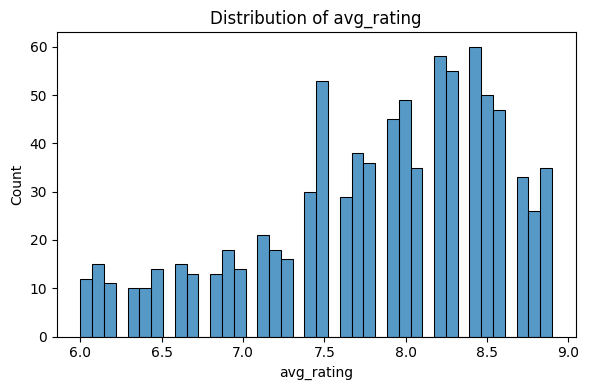

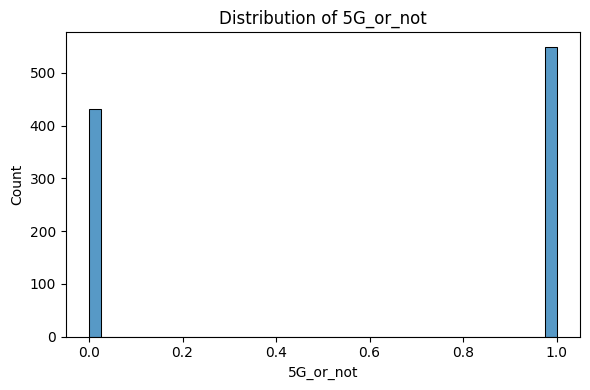

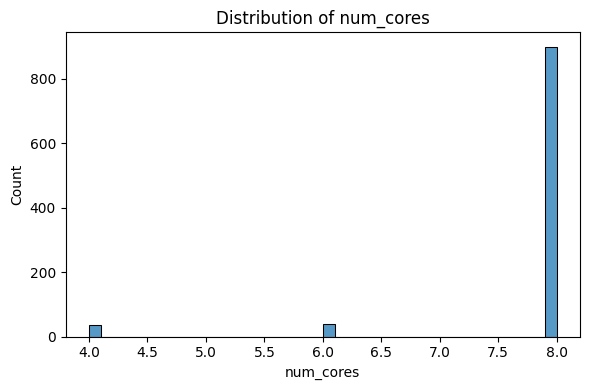

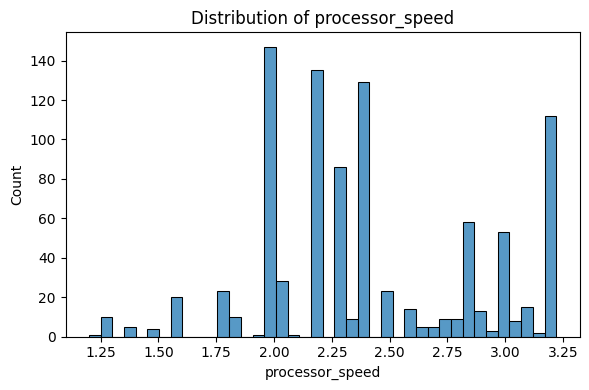

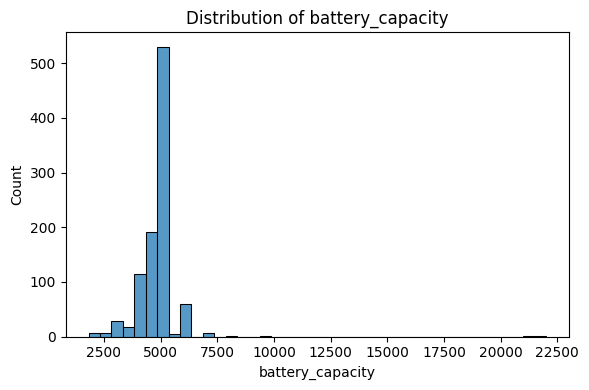

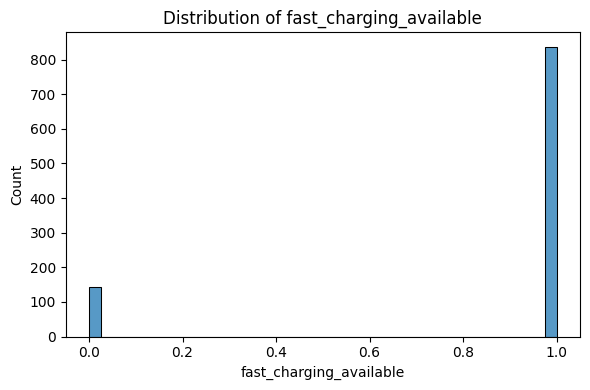

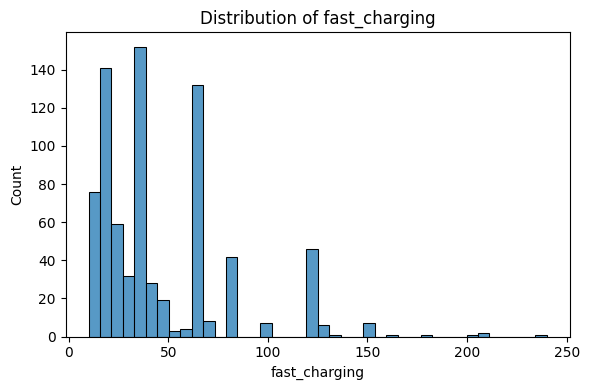

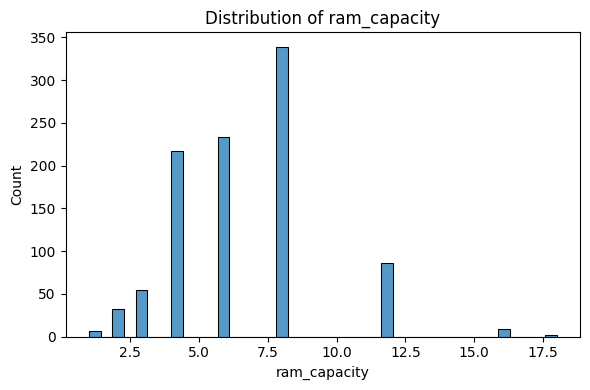

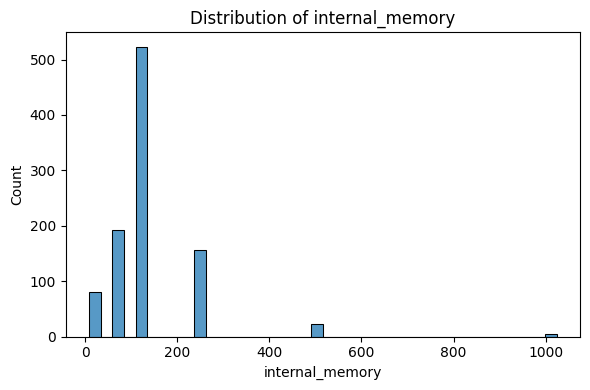

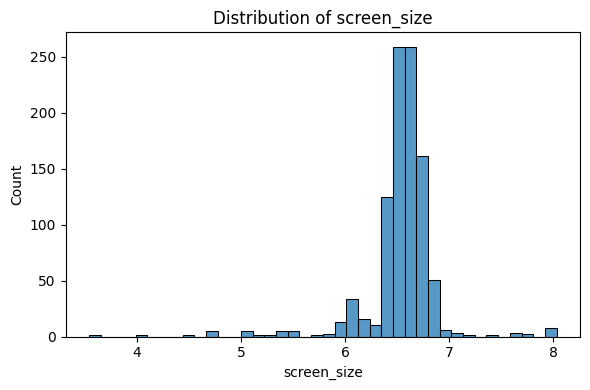

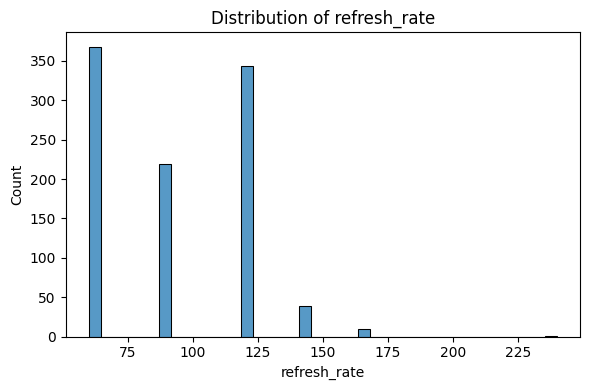

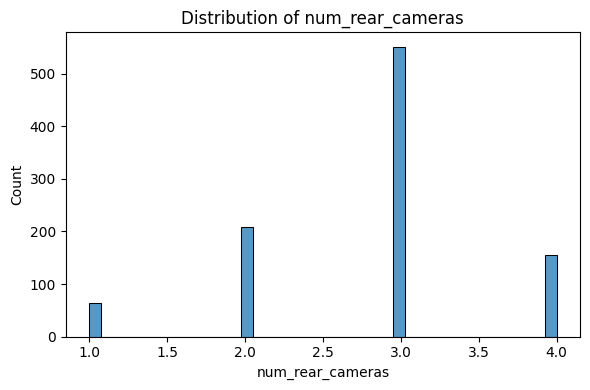

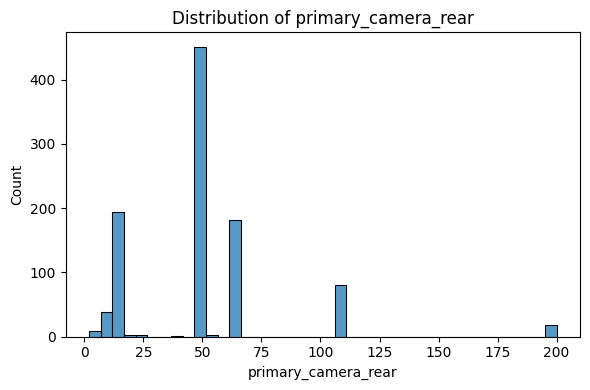

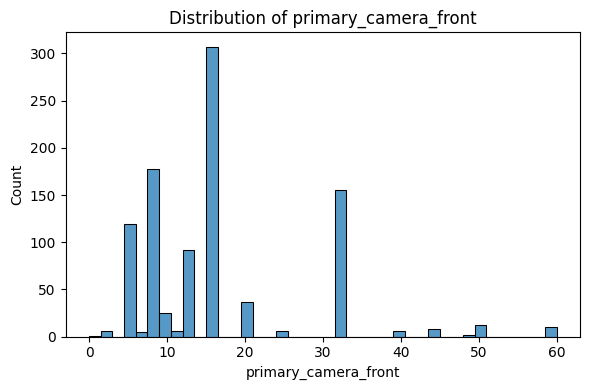

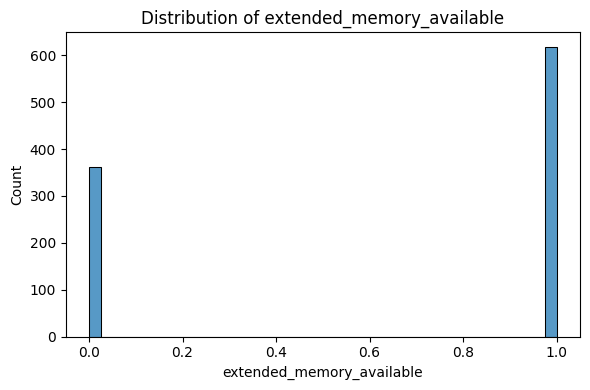

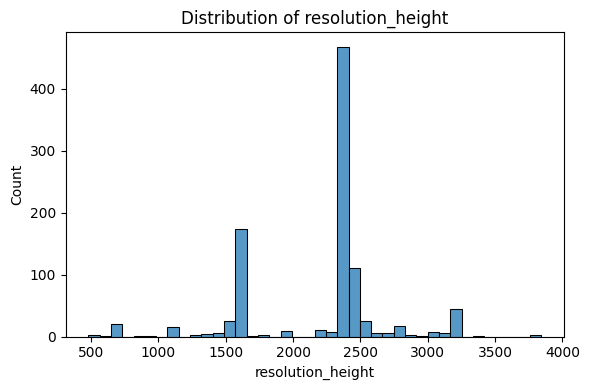

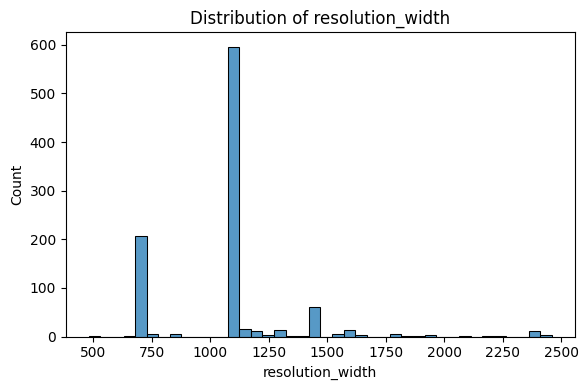

In [163]:
# Distribution and check
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=40)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

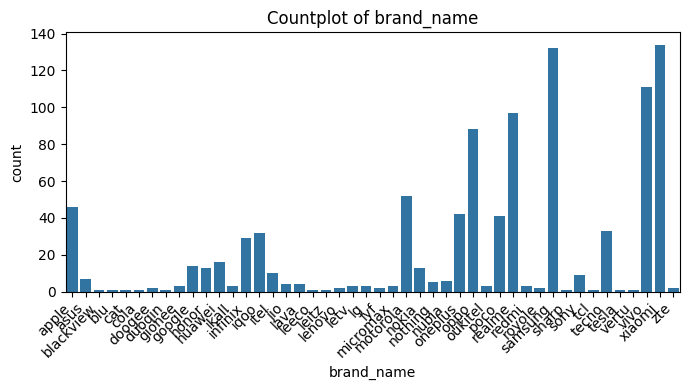

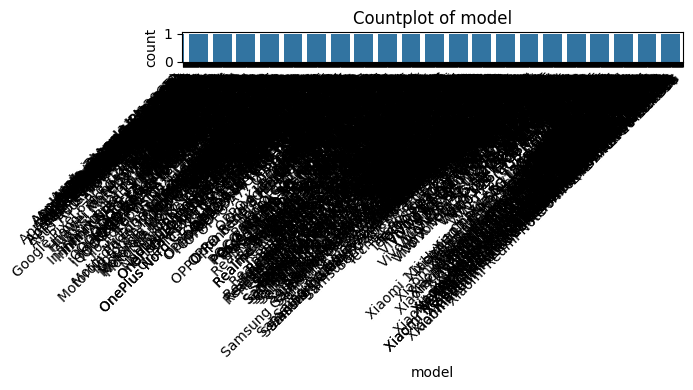

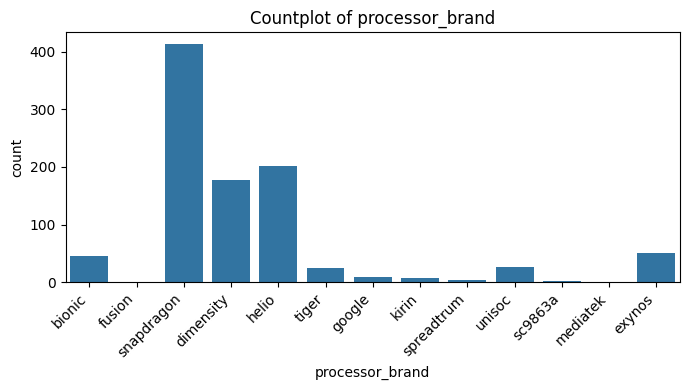

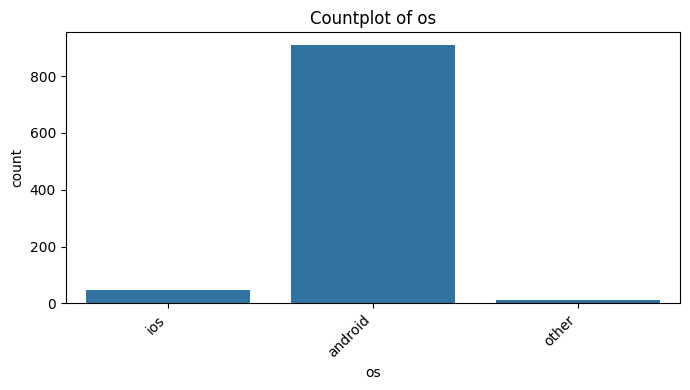

In [164]:
# Distribution and check
for col in cate_cols:
    plt.figure(figsize=(7, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

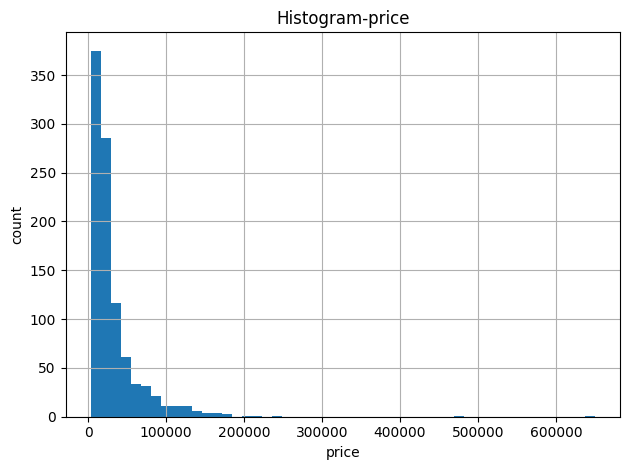

In [165]:
plt.figure()
df['price'].hist(bins=50)
plt.title("Histogram-price")
plt.xlabel("price"); plt.ylabel("count")
plt.tight_layout()



In [166]:
# Remove num_cores feature
df=df.drop(columns=['num_cores'])


##### Handle Missing and Outliers
- For numeric features used in modeling: impute with median during pipeline(safer, avoids target leakage).
- For categoricals: impute 'missing'token in pipeline
- Here, I only remove rows with missing target or impossible target values.

In [167]:
df=df[~df['price'].isna()].copy()
q1,q99=df['price'].quantile([0.01,0.99])
cap_low, cap_high=float(q1), float(q99)
df['price_capped']=df['price'].clip(lower=cap_low, upper=cap_high)

bq1,bq99=df['battery_capacity'].quantile([0.01,0.99])
df['battery_capacity_capped']=df['battery_capacity'].clip(lower=float(bq1), upper=float(bq99))
print("Price cap thresholds:", cap_low,cap_high)

Price cap thresholds: 5449.89 165034.2000000002


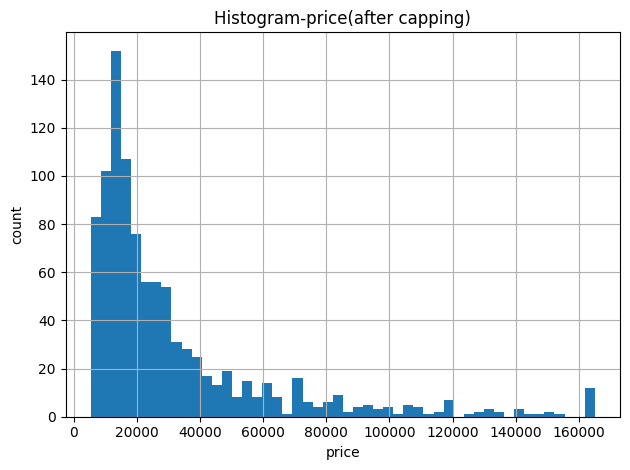

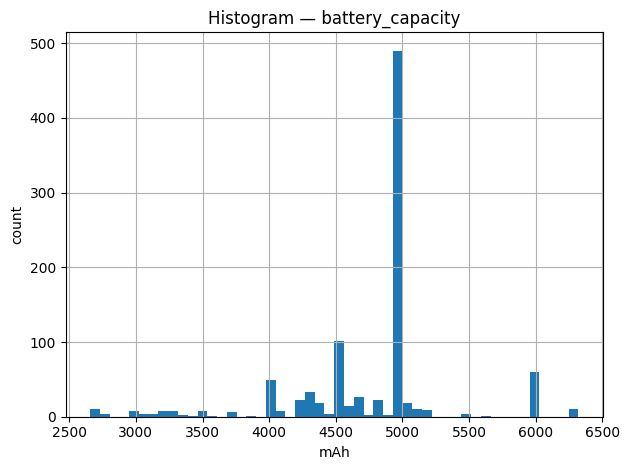

In [168]:
# plot after capping
plt.figure()
df['price_capped'].hist(bins=50)
plt.title("Histogram-price(after capping)")
plt.xlabel("price"); plt.ylabel("count")
plt.tight_layout()

plt.figure()
df['battery_capacity_capped'].hist(bins=50)
plt.title("Histogram — battery_capacity")
plt.xlabel("mAh"); plt.ylabel("count")
plt.tight_layout()

### 4) EDA-Inspect, Visualize, Analysis and Conclusion

#### 4A) Inspect and visualization

In [169]:
# Summary
display(df.describe(include='all').T)
# Numeric correlation with capped price
num_for_corr=df.select_dtypes(include=[np.number]).copy()
corr = num_for_corr.corr()['price_capped'].sort_values(ascending=False)
display(corr.to_frame('correlation_with_price_capped'))


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand_name,980,46,xiaomi,134,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,980,980,Apple iPhone 11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,980.0,NaN,NaN,NaN,32520.504082,39531.812669,3499.0,12999.0,19994.5,35491.5,650000.0
avg_rating,879.0,NaN,NaN,NaN,7.825825,0.740285,6.0,7.4,8.0,8.4,8.9
5G_or_not,980.0,NaN,NaN,NaN,0.560204,0.496616,0.0,0.0,1.0,1.0,1.0
processor_brand,960,13,snapdragon,413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
processor_speed,938.0,NaN,NaN,NaN,2.427217,0.46409,1.2,2.05,2.3,2.84,3.22
battery_capacity,969.0,NaN,NaN,NaN,4817.748194,1009.540054,1821.0,4500.0,5000.0,5000.0,22000.0
fast_charging_available,980.0,NaN,NaN,NaN,0.854082,0.353205,0.0,1.0,1.0,1.0,1.0
fast_charging,769.0,NaN,NaN,NaN,46.126138,34.27787,10.0,18.0,33.0,66.0,240.0


,correlation_with_price_capped
price_capped,1.000000
price,0.888016
internal_memory,0.689182
processor_speed,0.652936
ram_capacity,0.509280
resolution_height,0.458744
resolution_width,0.432093
5G_or_not,0.422764
avg_rating,0.419731
refresh_rate,0.344211


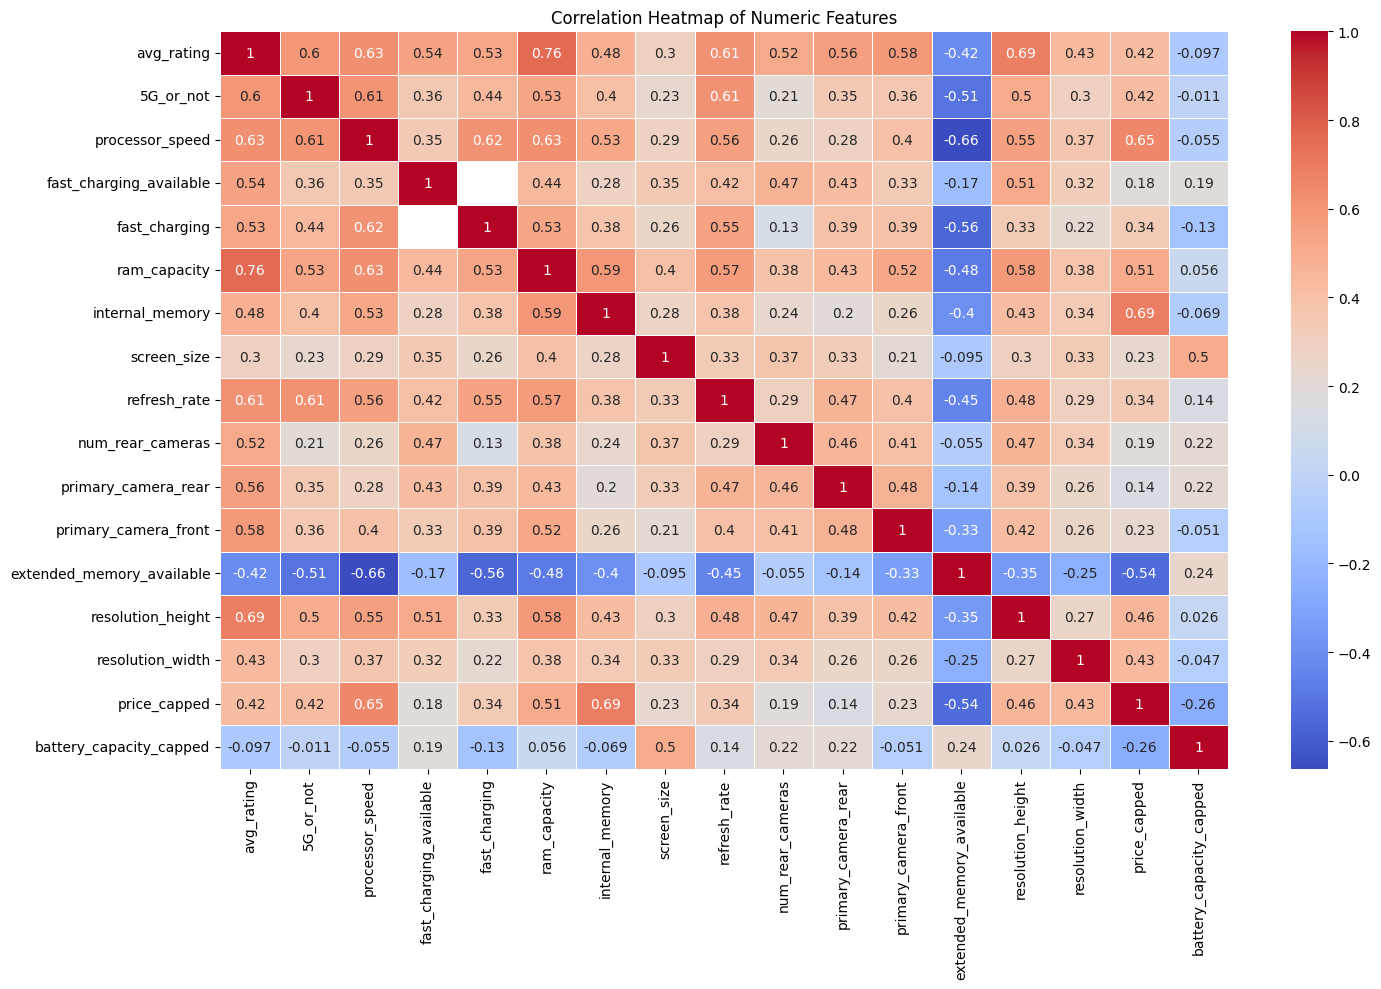

In [170]:
numeric_df = df.select_dtypes(include=['number']).drop(columns=['price','battery_capacity'], errors='ignore')

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

#### 4B) Analysis and Conclusion
- The dataset contains 980 smartphones with a mix of categorical features(brand,model, OS, processor band) and numeric specifications(battery, RAM, CPU speed, cameras, screen size, refresh rate...).
- Price is strongly right-skewed with several of very expensive devices; log transform often improves linear model fit and error symmetry.
- Correlations suggest storage capacity, CPU speed, RAM, resolution, 5G support, average user rating and refresh rate are the strongest drivers of prices. This indicates that higher storage, faster CPUs, more RAM, higher resolution/refresh, 5G support, and better user ratings are associated with higher prices.
-  Resolution height/width are collinear. For linear models we will rely on regularization or dimensionality reduction while tree ensembles handle this naturally.
-  Missingness is modest for 'avg_rating' and will be imputed within a pipeline( median for numeric, mode for categorical).
-  Outliers in 'price' and 'battery_capacity' will be capped for robust EDA and compared against log-price modeling to stabilize errors.

### 5) Processing and modeling
- Using multiple models: Ridge, RandomForestRegression, GradientBoostingRegressor.
- There is collinearity between features 'resolution_height' and 'resolution_width', regularize to handle collinearity in Ridge model.
- GradientBoostingRegressor: gradient boosting with subsampling to reduce overfitting.
- Feature engineering: drop 'price' and 'battery_cappacity', retain 'price_capped' and 'battery_capacity_capped' to reduce outlier influence.
- I select the best model by cross-validating RMSE.

In [183]:
from sklearn.impute import SimpleImputer
target='price_capped'
y=df[target].values
X=df.drop(columns=['price','battery_capacity','price_capped'])

# Identify numeric and categorical columns again after engineering
num_cols=X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols=X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_pipe=Pipeline(steps=[("impute", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_pipe=Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),
                                 ("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocess= ColumnTransformer(transformers=[("num", numeric_pipe, num_cols), 
                                            ("cat",categorical_pipe, cat_cols)], remainder="drop")
models={"ridge": Ridge(random_state=RANDOM_STATE), "rf": RandomForestRegressor(random_state=RANDOM_STATE), 
        "gbr": GradientBoostingRegressor(random_state=RANDOM_STATE)}
param_grids={"ridge": {"model__alpha": [0.1,1.0,3.0,10.0]},
             "rf": {"model__n_estimators":[200,400],"model__max_depth":[None,10,20],"model__min_samples_split":[2,5]},
             "gbr":{"model__n_estimators":[200,400],"model__learning_rate":[0.05,0.1],"model__max_depth":[2,3]}}

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results={}
best_model={}
for name, est in models.items():
    pipe=Pipeline(steps=[("pre",preprocess),("model", est)])
    grid=GridSearchCV(pipe, param_grid=param_grids[name], cv=cv,
                      scoring="neg_root_mean_squared_error", n_jobs=-1, refit=True, verbose=0)
    grid.fit(X_train, y_train)
    best_models[name]=grid.best_estimator_
    results[name]={"best_params": grid.best_params_,"rmse": -grid.best_score_}
    print(name, "->", grid.best_params_, "RMSE:", -grid.best_score_)

ridge -> {'model__alpha': 0.1} RMSE: 15307.125794026442
rf -> {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200} RMSE: 12272.191036319364
gbr -> {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 400} RMSE: 12432.573296342354


### 6) Results and analysis
- Summary of results and analysis and visualize using table and graphs.
- Use different kinds of evaluation metrics: rmse, mae,r2
- Iterate the training and evaluation process to improve the performance (log-price as a target)
- Compare the results from the multiple models.

#### 6A) Summary of results, evaluate different metrics and show visual summary

In [184]:
eval_rows=[]
for name, model in best_models.items():
    pred_train=model.predict(X_train)
    pred_test=model.predict(X_test)
    row={"model": name, "cv_rmse": results[name]["rmse"],
          "train_rmse": rmse(y_train, pred_train), "test_rmse": rmse(y_test,pred_test),
          "train_mae": mean_absolute_error(y_train, pred_train), "test_mae": mean_absolute_error(y_test, pred_test),
          "train_r2": r2_score(y_train,pred_train), "test_r2": r2_score(y_test,pred_test)}
    eval_rows.append(row)
eval_df=pd.DataFrame(eval_rows).sort_values("test_rmse")
display(eval_df)


,model,cv_rmse,train_rmse,test_rmse,train_mae,test_mae,train_r2,test_r2
2,gbr,12432.573296,3563.632040,8831.667407,2864.256682,5585.900202,0.986152,0.922541
1,rf,12272.191036,4578.808425,9145.294987,2169.585153,5205.384670,0.977138,0.916942
0,ridge,15307.125794,1204.386965,13478.390947,788.102449,9216.606504,0.998418,0.819590


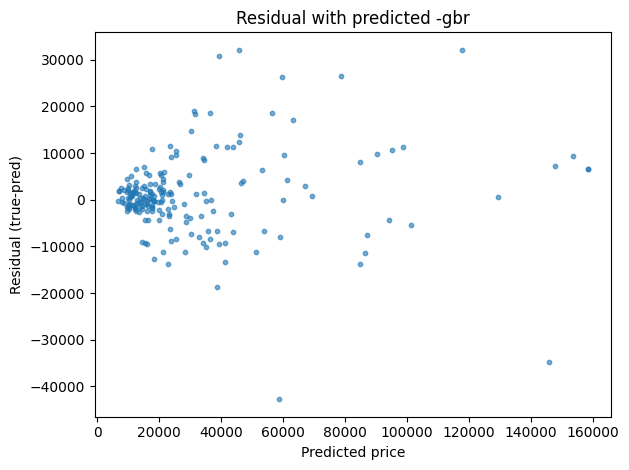

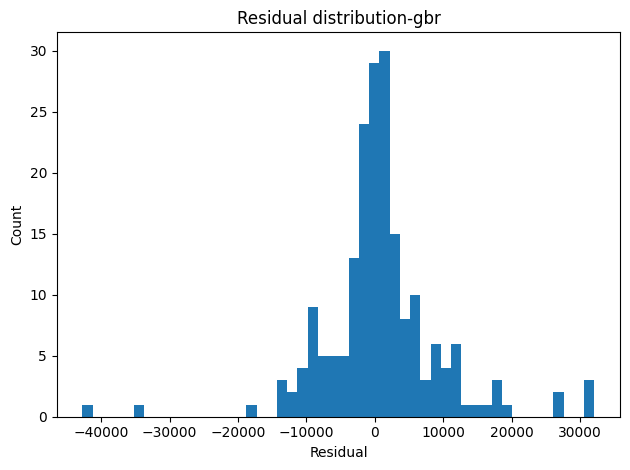

In [185]:
# Residual plot for best test RMSE
best_name=eval_df.iloc[0]['model']
best_model=best_models[best_name]
yhat=best_model.predict(X_test)
resid=y_test-yhat
plt.figure()
plt.scatter(yhat,resid,s=10,alpha=0.6)
plt.title(f"Residual with predicted -{best_name}")
plt.xlabel("Predicted price"); plt.ylabel("Residual (true-pred)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(resid, bins=50)
plt.title(f"Residual distribution-{best_name}")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### 6B) Iterate the training and evaluation process to improve the performance (log-price as a target)

In [180]:
y_log = np.log1p(y)
X_train, X_test, y_train_log, y_test_log=train_test_split(X, y_log, test_size=0.2, random_state=RANDOM_STATE)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results={}
best_model={}
for name, est in models.items():
    pipe=Pipeline(steps=[("pre",preprocess),("model", est)])
    grid=GridSearchCV(pipe, param_grid=param_grids[name], cv=cv,
                      scoring="neg_root_mean_squared_error", n_jobs=-1, refit=True, verbose=0)
    grid.fit(X_train, y_train_log)
    best_models[name]=grid.best_estimator_
    results[name]={"best_params": grid.best_params_,"rmse": -grid.best_score_}
    print(name, "->", grid.best_params_, "RMSE:", -grid.best_score_)


ridge -> {'model__alpha': 0.1} RMSE: 0.28055080463145565
rf -> {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200} RMSE: 0.260536662039673
gbr -> {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 400} RMSE: 0.25352343372458547


In [181]:
eval_rows=[]
for name, model in best_models.items():
    pred_train=model.predict(X_train)
    pred_test=model.predict(X_test)
    row={"model": name, "cv_rmse": results[name]["rmse"],
          "train_rmse": rmse(y_train_log, pred_train), "test_rmse": rmse(y_test_log,pred_test),
          "train_mae": mean_absolute_error(y_train_log, pred_train), "test_mae": mean_absolute_error(y_test_log, pred_test),
          "train_r2": r2_score(y_train_log,pred_train), "test_r2": r2_score(y_test_log,pred_test)}
    eval_rows.append(row)
eval_df=pd.DataFrame(eval_rows).sort_values("test_rmse")
display(eval_df)


,model,cv_rmse,train_rmse,test_rmse,train_mae,test_mae,train_r2,test_r2
2,gbr,0.253523,0.114687,0.236661,0.100529,0.169436,0.977755,0.904298
1,rf,0.260537,0.097336,0.245769,0.064214,0.171621,0.983977,0.896790
0,ridge,0.280551,0.021802,0.258074,0.016247,0.195784,0.999196,0.886197


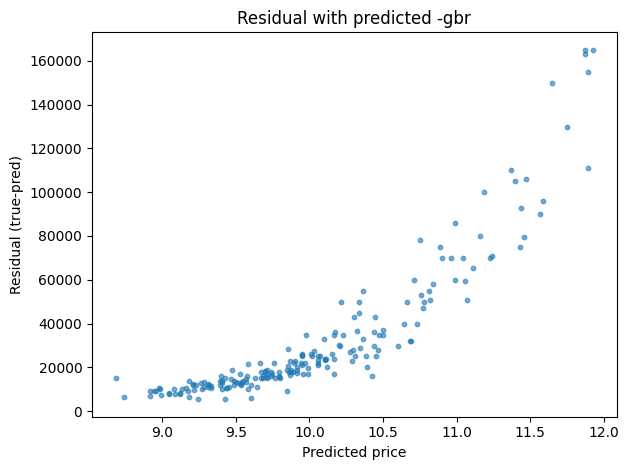

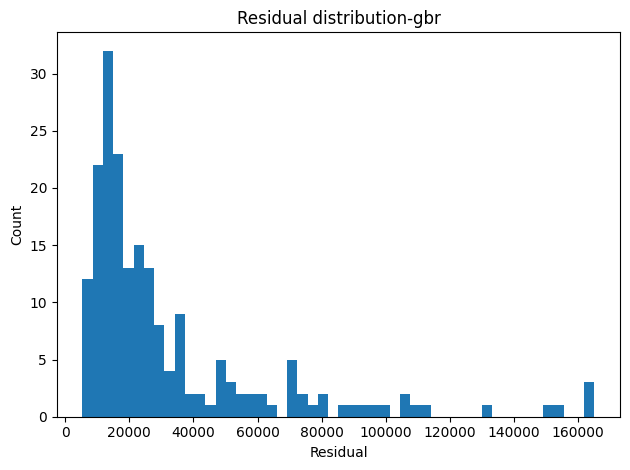

In [182]:
# Residual plot for best test RMSE
best_name=eval_df.iloc[0]['model']
best_model=best_models[best_name]
yhat=best_model.predict(X_test)
resid=y_test-yhat
plt.figure()
plt.scatter(yhat,resid,s=10,alpha=0.6)
plt.title(f"Residual with predicted -{best_name}")
plt.xlabel("Predicted price"); plt.ylabel("Residual (true-pred)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(resid, bins=50)
plt.title(f"Residual distribution-{best_name}")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### 6C) Compare the results from the multiple models.
I compared Ridge, Random Forest, and Gradient Boosting for price prediction. Both ensembles outperformed the linear baseline, with Gradient Boosting achieving the best test performance (RMSE: 0.237, MAE: 0.169, R2: 0.904), followed by Random Forest (RMSE: 0.246, MAE: 0.172, R2: 0.897). Ridge model with RMSE= 0.258, MAE= 0.196, R2= 0.886 indicates non-linear relationships and interactions. Train–test gaps show some overfitting for Ridge model with train_rmse=0.02 but test_rmse=0.26.

### 7) Discussion and conclusion
- The goal of this project was to build a supervised machine learning model to predict smartphone prices based on technical specifications and brand-related features. After performing extensive EDA, data cleaning, feature engineering, and model experimentation, I learn some key findings:
    + Ensemble models outperform linear models significantly.
    + Overfitting was observed in the ridge models.
    + Internal memory, processor speed, RAM capacity, and brand were among the strongest predictors. This reinforces real-world expectations that premium brands and better performance hardware associate with higher pricing.
- Ridge Regression underperformed because the feature–price relationship is not strictly linear. Even after adding scaled numerical features and encoding categoricals, the model could not generalize as well as non-linear ensemble methods.
- To further improve model performance, we can group rare brands and try more advanced models.